crypto factor model using deep neural nets
features: open, high, low, close, count, volume, rolling volatility, volume moving average, stddev of the close
predicts: close for time t + 1 with the features for t

In [43]:
#imports
from coin import Coin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential, load_model
from keras import layers
from keras.callbacks import EarlyStopping
from keras import optimizer_v2 as opt

In [50]:
#get data
coin = Coin('XXBTZUSD', interval='10080')
window = 10
nan = [None for _ in range(window)]
coin.tdata['percent_return'] = (coin.data.close-coin.data.close.shift(1))/coin.data.close.shift(1)
sma_volume = nan + [np.mean(coin.data.volume[i:i+window]) for i in range(len(coin.data.volume)-window)]
rolling_stddev = nan + [np.std(coin.data.close[i:i+window]) for i in range(len(coin.data.close)-window)]
rolling_volatility = nan + [None] + [np.std(coin.logrs[i:i+window]) for i in range(len(coin.logrs)-window)]
macd = nan + [np.mean(coin.data.close[i:i+window]) - np.mean(coin.data.close[i:i+int(window/2)]) for i in range(len(coin.data.close)-window)]
data = pd.concat([coin.tdata.drop(['time'],axis=1), pd.DataFrame({'sma_volume':sma_volume, 'rolling_stddev':rolling_stddev, 'rolling_volatility':rolling_volatility, 'macd':macd})], axis=1)
features = data.iloc[window+1:-1,:].reset_index(drop=True)
features

,open,high,low,close,vwap,volume,count,percent_return,sma_volume,rolling_stddev,rolling_volatility,macd
0,522.8,717.9,517.6,676.0,657.8,72.757792,724,0.242190,131.835964,329.356688,0.293159,286.63
1,684.5,771.0,677.9,759.1,732.0,46.368813,637,0.122929,138.766168,304.611236,0.293790,249.57
2,750.1,1019.0,750.1,824.5,870.8,87.771089,734,0.086155,142.786351,280.103674,0.285707,148.25
3,825.5,918.0,805.0,855.9,849.3,46.365953,331,0.038084,133.141459,243.447442,0.283145,35.09
4,842.7,855.0,788.0,822.0,831.9,43.245531,359,-0.039607,134.839168,197.961380,0.281660,-26.99
...,...,...,...,...,...,...,...,...,...,...,...,...
431,42910.2,48200.0,42637.4,47059.3,45718.3,16345.001708,238446,0.096690,23674.825169,2858.936274,0.105261,346.20
432,47079.2,47598.0,43123.7,43179.4,45550.1,17550.482020,192705,-0.082447,23972.085635,3378.522564,0.107312,1770.73
433,43179.5,43968.7,39240.0,41150.0,41568.2,13435.433507,156961,-0.046999,22117.727427,2991.717508,0.103026,986.93
434,41150.0,42235.7,38570.0,41369.9,40501.9,10551.707740,137281,0.005344,21631.529871,2454.219943,0.104786,399.20


In [55]:
#preprocessing
labels = coin.tdata.close[window+2:].reset_index(drop=True)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=.2)
ct = ColumnTransformer([('only numeric', StandardScaler(), features.columns)], remainder='passthrough')
features_train = ct.fit_transform(features_train)
features_test = ct.fit_transform(features_test)

In [61]:
#model creation
def return_model():
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(features.shape[1],)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.15))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.15))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(.1))
    model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, name='Output'))
    model.compile(loss='mse', optimizer=opt.adam.Adam(learning_rate=0.000015), metrics=['mape','mae'])
    model.summary()
    return model
model = return_model()
    

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 512)               6656      
                                                                 
 dropout_32 (Dropout)        (None, 512)               0         
                                                                 
 dense_57 (Dense)            (None, 256)               131328    
                                                                 
 dropout_33 (Dropout)        (None, 256)               0         
                                                                 
 dense_58 (Dense)            (None, 128)               32896     
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_59 (Dense)            (None, 128)              

In [62]:
#training
es = EarlyStopping(monitor='val_loss', mode='min', patience=100)
history = model.fit(features_train, labels_train, epochs=5000, batch_size=10, validation_split=.15, verbose=2, callbacks=[es])

Epoch 1/5000
30/30 - 2s - loss: 387804928.0000 - mape: 100.0004 - mae: 11234.1699 - val_loss: 228115744.0000 - val_mape: 99.9993 - val_mae: 7858.0303 - 2s/epoch - 73ms/step
Epoch 2/5000
30/30 - 1s - loss: 387803744.0000 - mape: 99.9978 - mae: 11234.1357 - val_loss: 228114544.0000 - val_mape: 99.9955 - val_mae: 7857.9912 - 570ms/epoch - 19ms/step
Epoch 3/5000
30/30 - 0s - loss: 387801696.0000 - mape: 99.9941 - mae: 11234.0898 - val_loss: 228113200.0000 - val_mape: 99.9903 - val_mae: 7857.9443 - 246ms/epoch - 8ms/step
Epoch 4/5000
30/30 - 0s - loss: 387799712.0000 - mape: 99.9899 - mae: 11234.0391 - val_loss: 228111568.0000 - val_mape: 99.9838 - val_mae: 7857.8857 - 229ms/epoch - 8ms/step
Epoch 5/5000
30/30 - 0s - loss: 387797344.0000 - mape: 99.9851 - mae: 11233.9775 - val_loss: 228109568.0000 - val_mape: 99.9759 - val_mae: 7857.8130 - 249ms/epoch - 8ms/step
Epoch 6/5000
30/30 - 0s - loss: 387793408.0000 - mape: 99.9789 - mae: 11233.8896 - val_loss: 228106768.0000 - val_mape: 99.9665 - 

['true', 'pred', 'pred-true', 'pred-true%'] [759.1, '859.33', '100.23', '13.20%'] [824.5, '733.84', '-90.66', '-11.00%'] [855.9, '715.16', '-140.74', '-16.44%'] [822.0, '725.43', '-96.57', '-11.75%'] [802.4, '817.68', '15.28', '1.90%'] [802.5, '731.67', '-70.83', '-8.83%'] [670.6, '632.81', '-37.79', '-5.63%'] [630.1, '901.63', '271.53', '43.09%'] [587.2, '545.03', '-42.17', '-7.18%'] [680.9, '528.06', '-152.84', '-22.45%'] [631.6, '469.75', '-161.85', '-25.63%'] [620.0, '396.71', '-223.29', '-36.01%'] [585.0, '386.33', '-198.67', '-33.96%'] [448.3, '388.86', '-59.44', '-13.26%'] [461.0, '525.06', '64.06', '13.90%'] [523.5, '387.77', '-135.73', '-25.93%'] [495.6, '436.06', '-59.54', '-12.01%'] [448.3, '403.36', '-44.94', '-10.02%'] [452.7, '420.48', '-32.22', '-7.12%'] [445.5, '390.60', '-54.90', '-12.32%'] [494.7, '390.79', '-103.91', '-21.01%'] [575.8, '419.59', '-156.21', '-27.13%'] [640.4, '473.03', '-167.37', '-26.14%'] [617.9, '424.04', '-193.86', '-31.37%'] [603.5, '402.47', '-2

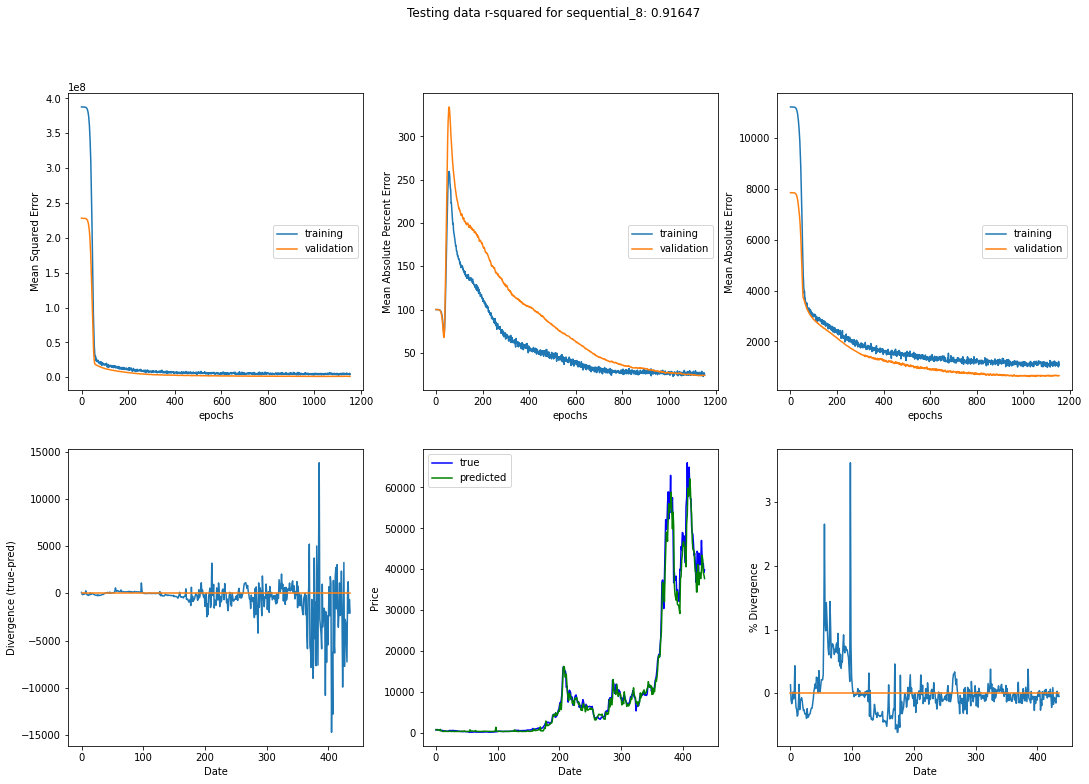

In [63]:
#show metrics for current model
fig = plt.figure('Evaluation', figsize=(18,12))
test_prediction = model.predict(features_test)
ftr = ct.fit_transform(features)
dates = coin.data.time[window+2:].reset_index(drop=True)
prediction = [p[0] for p in model.predict(ftr)]
divergence = [pred-true for true, pred in zip(labels, prediction)]
percent_divergence = [(pred-true)/true for true, pred in zip(labels, prediction)]
r2 = r2_score(test_prediction, labels_test)
fig.suptitle(f'Testing data r-squared for {model.name}: {r2:.5f}')

ax1 = fig.add_subplot(2,3,1)
ax1.plot(history.history['loss'], label='training')
ax1.plot(history.history['val_loss'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Mean Squared Error')
ax1.legend(loc='center right')

ax2 = fig.add_subplot(2,3,2)
ax2.plot(history.history['mape'], label='training')
ax2.plot(history.history['val_mape'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Mean Absolute Percent Error')
ax2.legend(loc='center right')

ax3 = fig.add_subplot(2,3,3)
ax3.plot(history.history['mae'], label='training')
ax3.plot(history.history['val_mae'], label='validation')
ax3.set_xlabel('epochs')
ax3.set_ylabel('Mean Absolute Error')
ax3.legend(loc='center right')

ax4 = fig.add_subplot(2,3,4)
ax4.plot(range(len(dates)), divergence)
ax4.plot([0 for _ in range(len(dates))])
ax4.set_xlabel('Date')
ax4.set_ylabel('Divergence (true-pred)')

ax5 = fig.add_subplot(2,3,5)
ax5.plot(range(len(dates)), labels, label='true', color='blue')
ax5.plot(prediction, label='predicted', color='green')
ax5.set_xlabel('Date')
ax5.set_ylabel('Price')
ax5.legend(loc='upper left')

ax6 = fig.add_subplot(2,3,6)
ax6.plot(range(len(dates)), percent_divergence)
ax6.plot([0 for _ in range(len(dates))])
ax6.set_xlabel('Date')
ax6.set_ylabel('% Divergence')

comp = [[true,f'{pred:.2f}',f'{pred-true:.2f}',f'{(pred-true)/true:.2%}'] for true, pred in zip(labels, prediction)]
comp = [['true','pred','pred-true','pred-true%']] + comp
print(*comp)

Current r-squared: 0.91647 | Loaded r-squared: 0.91797


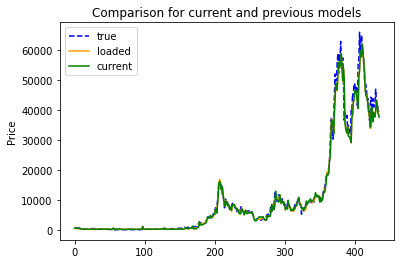

In [64]:
#compare metrics for current model vs loaded model
loaded = load_model('saves/XXBTZUSD_f12_r9179')
loaded_test_prediction = loaded.predict(features_test)
loaded_prediction = [p[0] for p in loaded.predict(ct.fit_transform(features))]
loaded_r2 = r2_score(loaded_test_prediction, labels_test)
print(f'Current r-squared: {r2:.5f} | Loaded r-squared: {loaded_r2:.5f}')
plt.plot(range(len(labels)), labels, label='true', color='blue', linestyle='--')
plt.plot(loaded_prediction, label='loaded', color='orange')
plt.plot(prediction, label='current', color='green')
plt.title('Comparison for current and previous models')
plt.legend(loc='upper left')
plt.ylabel('Price')
plt.show()

In [65]:
#save model
model.save(f'saves/{coin.pair}_f{features.shape[1]}_r{int(r2*10000)}')
# loaded.save(f'saves/{coin.pair}_f{features.shape[1]}_r{int(loaded_r2*10000)}')

INFO:tensorflow:Assets written to: saves/XXBTZUSD_f12_r9164/assets
